# INSA 5IF OT8 Text Mining - TP1 Text classification

## 0. Configuration

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
import numpy as np
from langchain_openai import OpenAIEmbeddings
from pathlib import Path
from tqdm import tqdm
from scipy.spatial.distance import cdist
import hashlib
import matplotlib.pyplot as plt

In [45]:
load_dotenv();

In [46]:
RANDOM_STATE = 42
EMBEDDING_MODEL = "text-embedding-3-small"

## 1. Data preparation

### 1.1. Load data

In [47]:
data = pd.read_csv("data/stack-overflow-data.csv")
data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


### 1.2. Embed data

In [48]:
def embed(
    data: list,
    model: str = EMBEDDING_MODEL,
    cache_path: str = "data/embeddings/embed-{hash}-{model}.npy",
) -> np.ndarray:
    cache_file = Path(
        cache_path.format(
            hash=hashlib.sha1(str(data).encode()).hexdigest(), model=model
        )
    )

    if cache_file.exists():
        print(f"Loading embeddings from cache: {cache_file}")
        return np.load(cache_file)

    embeddings_client = OpenAIEmbeddings(model=model)
    embeddings = np.array(embeddings_client.embed_documents(data))

    print(f"Saving embeddings to cache: {cache_file}")
    cache_file.parent.mkdir(parents=True, exist_ok=True)
    np.save(cache_file, embeddings)

    return embeddings

In [49]:
embeddings = embed(data["post"].tolist())

print("Computed embeddings shape:", embeddings.shape)

Loading embeddings from cache: data/embeddings/embed-fb5c5302b9e9645addea8fe2b9b89d86a91d9fb9-text-embedding-3-small.npy
Computed embeddings shape: (40000, 1536)


### 1.3. Split data

In [50]:
train_data, test_data = train_test_split(
    data, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Training data shape: {train_data.shape})")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (30000, 2))
Testing data shape: (10000, 2)


## 2. Data exploration

In [51]:
print(f"Tags counts: {data["tags"].nunique()}")
print(f"Tags: {', '.join(data["tags"].unique())}")

Tags counts: 20
Tags: c#, asp.net, objective-c, .net, python, angularjs, iphone, ruby-on-rails, ios, c, sql, java, jquery, css, c++, php, android, mysql, javascript, html


In [52]:
from sklearn.decomposition import PCA

sample = np.random.choice(embeddings.shape[0], 10000, replace=False)

pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings[sample])

reduced_tags = data["tags"].iloc[sample]

print("Reduced embeddings shape:", reduced_embeddings.shape)

Reduced embeddings shape: (10000, 3)


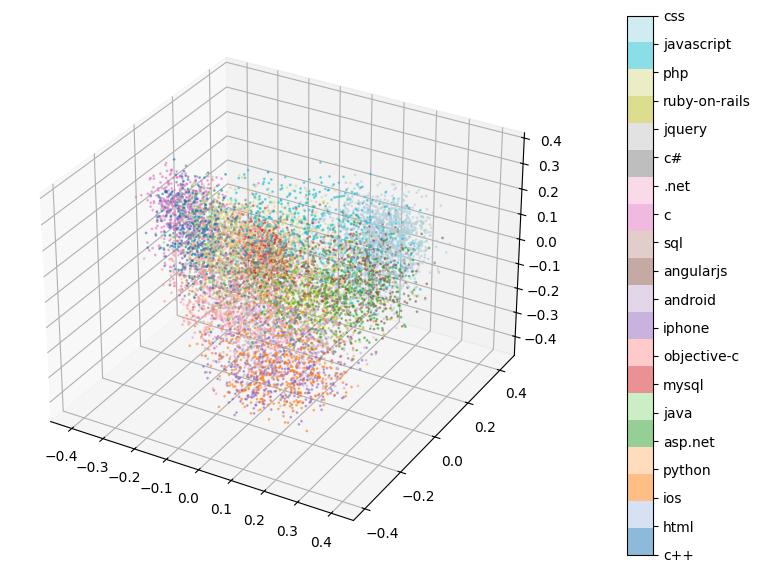

In [53]:
# Create a color map for the tags
unique_tags = reduced_tags.unique().tolist()
color_map = {tag: idx for idx, tag in enumerate(unique_tags)}
colors = reduced_tags.map(color_map)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    reduced_embeddings[:, 2],
    c=colors,
    cmap="tab20",
    s=1,
    alpha=0.5,
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_ticks(range(len(unique_tags)))
cbar.set_ticklabels(unique_tags)

plt.show()

## 3. Prediction

In [54]:
train_group_data = train_data.groupby("tags")
train_group_tags = list(map(lambda x: x[0], train_group_data))

### 3.1. Centroid-based prediction

In [55]:
train_group_data_centroids = np.vstack(
    [np.mean(embeddings[group.index], axis=0) for (_, group) in train_group_data]
)

train_group_data_centroids.shape

(20, 1536)

In [56]:
results = test_data[["tags"]].copy()
results["predicted"] = None
results_prediction = []

for test_embedding in tqdm(embeddings[test_data.index], desc="Predicting"):
    distances = cdist(train_group_data_centroids, [test_embedding], metric="cosine")

    predicted_tag_index = np.argmin(distances)
    predicted_tag = train_group_tags[predicted_tag_index]

    results_prediction.append(predicted_tag)

results["predicted"] = results_prediction

Predicting: 100%|██████████| 10000/10000 [00:00<00:00, 12937.52it/s]


In [57]:
results["accurate"] = results["tags"] == results["predicted"]
success_count = results["accurate"].sum()

print(f"Success rate: {success_count / len(results) * 100:.2f}%")

Success rate: 81.34%
